In [1]:
import pandas as pd
import numpy as np
import os

In [5]:
def extract_paras_columns(excel_filename,sheet_name,file_root="",csv_generate_flag=False):
    rawData=pd.read_excel(os.path.join(file_root,excel_filename),sheet_name=sheet_name)
    columns_list=list(rawData.columns)
    para_columns_list=[]
    for column in columns_list:
        if 'TIME' not in column:
            para_columns_list.append(column)
    df_para=rawData[para_columns_list].copy()
    df_para['label']=0
    df_para['label'][df_para['Y']>0]=1
#     print(df_para.info())
    if(csv_generate_flag):
        df_M3_CLA_para.to_csv(os.path.join(file_root,"data_generate",excel_filename[:-5]+"_paras.csv"),index=False)
    return df_para

In [6]:
df_M3_CLA=extract_paras_columns("./data/M3-CLA.xlsx",'1_1')
df_M3_CLA.drop(columns=['SHEET_ID','Y','OPERATION_ID','TOOL_ID','ABBR_NO','RECIPE_ID'],inplace=True)
df_M3_CLA=df_M3_CLA.fillna(-1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
new_col=[]
total=df_M3_CLA.shape[0]
for _ in df_M3_CLA.columns:
    a=pd.value_counts(df_M3_CLA[_])
    df_=a/total
    print(_,max(df_))
    if (max(df_)<0.95):
        new_col.append(_)
new_col.remove('label')
print(new_col)

AK_Process_QUANTITY 0.011299435028248588
EQ_Process_QUANTITY 0.011299435028248588
Glass Data 0.5819209039548022
HPMJ/FS_Process_QUANTITY 0.011299435028248588
IN_CV_HEPA_Run (0:OFF//1:ON) 1.0
IN_CV_ION_BAR_Run (0:OFF//1:ON) 1.0
IN_CV_SPEED 0.7909604519774012
NE_HEPA_Run (0:OFF//1:ON) 1.0
NE_Process_QUANTITY 0.011299435028248588
Out_CV_ESD_MONITOR 0.11016949152542373
Out_CV_HEPA_Run (0:OFF//1:ON) 1.0
Out_CV_ION_BAR_Run (0:OFF//1:ON) 1.0
Out_CV_SPEED 1.0
PANEL_LENGTH 1.0
PANEL_THICKNESS 1.0
PANEL_WIDTH_ 1.0
PROCESS_CV_SPEED 1.0
SH/KJ_Process_QUANTITY 0.011299435028248588
label 0.7231638418079096
['AK_Process_QUANTITY', 'EQ_Process_QUANTITY', 'Glass Data', 'HPMJ/FS_Process_QUANTITY', 'IN_CV_SPEED', 'NE_Process_QUANTITY', 'Out_CV_ESD_MONITOR', 'SH/KJ_Process_QUANTITY']


In [8]:
# df_M3_CLA.info()
data_array=df_M3_CLA[new_col].values
label_array=df_M3_CLA['label'].values
print(data_array.shape,label_array.shape)

(354, 8) (354,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(data_array,label_array,test_size=0.1, random_state=0)

In [10]:
import xgboost as xgb

In [11]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
trn_data = xgb.DMatrix(X_train, y_train)
val_data = xgb.DMatrix(X_test, y_test)
watchlist = [(trn_data, 'train'),(val_data,'validation')]

clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=2000,
                    verbose_eval=100, params=xgb_params)

[0]	train-auc:0.85337	validation-auc:0.801003
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 2000 rounds.
[100]	train-auc:0.926079	validation-auc:0.847826
[200]	train-auc:0.940621	validation-auc:0.841137
[300]	train-auc:0.950543	validation-auc:0.847826
[400]	train-auc:0.959682	validation-auc:0.844482
[500]	train-auc:0.96559	validation-auc:0.844482
[600]	train-auc:0.972254	validation-auc:0.851171
[700]	train-auc:0.977708	validation-auc:0.854515
[800]	train-auc:0.981747	validation-auc:0.85786
[900]	train-auc:0.984474	validation-auc:0.85786
[1000]	train-auc:0.985988	validation-auc:0.861204
[1100]	train-auc:0.987655	validation-auc:0.861204
[1200]	train-auc:0.989119	validation-auc:0.861204
[1300]	train-auc:0.990533	validation-auc:0.861204
[1400]	train-auc:0.991896	validation-auc:0.877926
[1500]	train-auc:0.992805	validation-auc:0.877926
[1600]	train-auc:0.993613	validation-auc:0.881271
[1700]	trai

In [12]:
# for _ in range(10)
clf.get_score()

{'f6': 9980,
 'f2': 6701,
 'f1': 7989,
 'f7': 2946,
 'f0': 26799,
 'f4': 2032,
 'f3': 1154,
 'f5': 184}

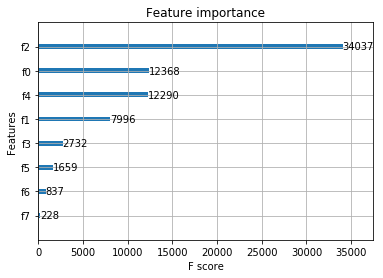

In [29]:
import matplotlib.pyplot as plt
xgb.plot_importance(booster=clf)
plt.show()

In [30]:
new_col

['Out_CV_ESD_MONITOR',
 'Glass Data',
 'AK_Process_QUANTITY',
 'IN_CV_SPEED',
 'SH/KJ_Process_QUANTITY',
 'HPMJ/FS_Process_QUANTITY',
 'EQ_Process_QUANTITY',
 'NE_Process_QUANTITY']

In [ ]:
# clf=xgb.XGBClassifier(eta= 0.005,
#               max_depth= 10 ,
#               min_child_weight= 1 ,
#               subsample=0.8 ,
#               colsample_bytree= 0.8 ,
#               eval_metric='auc',
#               objective= 'binary:logistic',
#               booster="gbtree",
#               silent= True)
# clf.fit(X=X_train,y=y_train,eval_set=[(X_test,y_test)],eval_metric='auc',verbose=True)